## CNN Classifier V1 - Vacation Images
This version uses 16 output channels after convolution. The script is kept simple without hyperparameter optimization.
Models with different batch_size during loading the data will be saved with different name. 

### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Script Runtime Start

In [2]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [3]:
script_start = start_time_()

### Initialize GPU

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [5]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [6]:
#paths to be used for dataloaders later on
path_to_train = './img_data/train/'
path_to_val = './img_data/val/'
path_to_test = './img_data/test/'

### Define data tranformations

In [7]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.RandomHorizontalFlip(0.3), 
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [8]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [9]:
#Define Loaders



#==============#
batch_size = 4
#==============#



train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True)

### Unnormalize pictures for visualization later

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [11]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [12]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #input_dim = 128, output_dim = 124
        self.pool = nn.MaxPool2d(2,2) #(kernelsize, stride)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) # input_dim = 62 (after pooling). output_dim (after 2nd pooling) = 30
        self.conv3 = nn.Conv2d(16, 16, 5) # input_dim = 30 , output_dim (after 3rd pooling)= 13
        
        self.fc1 = nn.Linear(16 * 13 * 13, 120) #(16 channel * 13 * 13 (image size))
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
cnn = CNN().to(device)

### Define loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### Train network

In [15]:
#=========#
epochs = 70
#=========#

In [16]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [17]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
    validation_loss.append(valid_loss / len(val_loader))
    
    
    #console output for tracking
    #______________________________________________________
    print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/cnn_net_b{batch_size}_e{epochs}_v1.pth') 
        
        
#==========================================================================


print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training is :", Execution_time(train_start, train_end))

  0%|                                                                                          | 0/522 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 0.676735592470772 		 Validation Loss: 0.6718990763028463
Validation Loss Decreased(inf--->50.392431) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 2 		 Training Loss: 0.6698460980279236 		 Validation Loss: 0.6657447075843811
Validation Loss Decreased(50.392431--->49.930853) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 3 		 Training Loss: 0.6337180607506142 		 Validation Loss: 0.6019351903597514
Validation Loss Decreased(49.930853--->45.145139) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 4 		 Training Loss: 0.6003876867707661 		 Validation Loss: 0.5948316790660222
Validation Loss Decreased(45.145139--->44.612376) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 5 		 Training Loss: 0.562942194912968 		 Validation Loss: 0.5733487731218339
Validation Loss Decreased(44.612376--->43.001158) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 6 		 Training Loss: 0.5302180525101008 		 Validation Loss: 0.5064229222138723
Validation Loss Decreased(43.001158--->37.981719) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 7 		 Training Loss: 0.45681238839923766 		 Validation Loss: 0.44716115812460583
Validation Loss Decreased(37.981719--->33.537087) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 8 		 Training Loss: 0.4584475322073447 		 Validation Loss: 0.45420523385206857


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 9 		 Training Loss: 0.4368988923814105 		 Validation Loss: 0.41632101813952127
Validation Loss Decreased(33.537087--->31.224076) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 10 		 Training Loss: 0.40154017744250453 		 Validation Loss: 0.4153163653612137
Validation Loss Decreased(31.224076--->31.148727) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 11 		 Training Loss: 0.38523013934928396 		 Validation Loss: 0.42579119294881823


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 12 		 Training Loss: 0.36648801374837925 		 Validation Loss: 0.31021402023732664
Validation Loss Decreased(31.148727--->23.266052) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 13 		 Training Loss: 0.3832424393715872 		 Validation Loss: 0.33059230928619704


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 14 		 Training Loss: 0.3457232244362719 		 Validation Loss: 0.3543231661617756


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 15 		 Training Loss: 0.344069483516902 		 Validation Loss: 0.2968346056342125
Validation Loss Decreased(23.266052--->22.262595) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 16 		 Training Loss: 0.3315859369530389 		 Validation Loss: 0.30530469680825867


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 17 		 Training Loss: 0.3303108834929165 		 Validation Loss: 0.3084079538285732


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 18 		 Training Loss: 0.3342586010248468 		 Validation Loss: 0.3522397321959337


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 19 		 Training Loss: 0.3350632937100513 		 Validation Loss: 0.27783058168987435
Validation Loss Decreased(22.262595--->20.837294) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 20 		 Training Loss: 0.3140295815290134 		 Validation Loss: 0.2960196240743001


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 21 		 Training Loss: 0.30492257406770956 		 Validation Loss: 0.2791118589711065


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 22 		 Training Loss: 0.3105011610751365 		 Validation Loss: 0.2638515953471263
Validation Loss Decreased(20.837294--->19.788870) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 23 		 Training Loss: 0.2909501593442227 		 Validation Loss: 0.37826000242649266


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 24 		 Training Loss: 0.29598570017989767 		 Validation Loss: 0.2842016206433376


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 25 		 Training Loss: 0.2765959401033333 		 Validation Loss: 0.24692185875028372
Validation Loss Decreased(19.788870--->18.519139) 	 Saving The Model


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 26 		 Training Loss: 0.2861723988700544 		 Validation Loss: 0.26317517915119726


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 27 		 Training Loss: 0.28236478963649164 		 Validation Loss: 0.2808337093750015


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 28 		 Training Loss: 0.2936778017569519 		 Validation Loss: 0.28739694895843665


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 29 		 Training Loss: 0.27821852521742496 		 Validation Loss: 0.2710965757196148


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 30 		 Training Loss: 0.26156941800417516 		 Validation Loss: 0.3076282206426064


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 31 		 Training Loss: 0.2598973103108463 		 Validation Loss: 0.26827831484377385


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 32 		 Training Loss: 0.24229802180731033 		 Validation Loss: 0.2706295278202742


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 33 		 Training Loss: 0.23032181490123138 		 Validation Loss: 0.28836485537389916


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 34 		 Training Loss: 0.23122771224720667 		 Validation Loss: 0.29550399803866945


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 35 		 Training Loss: 0.2497107357050335 		 Validation Loss: 0.28179835272952913


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 36 		 Training Loss: 0.23904206726782137 		 Validation Loss: 0.26886683601109934


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 37 		 Training Loss: 0.22586027059393624 		 Validation Loss: 0.2695607142398755


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 38 		 Training Loss: 0.23289310713378905 		 Validation Loss: 0.3031749620218761


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 39 		 Training Loss: 0.2222961952443274 		 Validation Loss: 0.3151934553993245


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 40 		 Training Loss: 0.21043985732095102 		 Validation Loss: 0.30926554164538783


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 41 		 Training Loss: 0.2038203806186945 		 Validation Loss: 0.29599231848231283


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 42 		 Training Loss: 0.21161906001799458 		 Validation Loss: 0.3087363985646516


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 43 		 Training Loss: 0.20779135105266125 		 Validation Loss: 0.2958468197907011


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 44 		 Training Loss: 0.17992784749757557 		 Validation Loss: 0.3058579232310876


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 45 		 Training Loss: 0.19746717895193594 		 Validation Loss: 0.3268122938585778


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 46 		 Training Loss: 0.19236516204936488 		 Validation Loss: 0.2918502175854519


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 47 		 Training Loss: 0.19770611704271857 		 Validation Loss: 0.43511613493317175


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 48 		 Training Loss: 0.17582150980659808 		 Validation Loss: 0.3356253398101156


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 49 		 Training Loss: 0.19201631507950245 		 Validation Loss: 0.31821101309576383


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 50 		 Training Loss: 0.19390865883393432 		 Validation Loss: 0.2898986748854319


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 51 		 Training Loss: 0.16856053918470731 		 Validation Loss: 0.353564806090047


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 52 		 Training Loss: 0.14960382170637337 		 Validation Loss: 0.30953684459847863


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 53 		 Training Loss: 0.16191936969949572 		 Validation Loss: 0.27677781036744514


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 54 		 Training Loss: 0.14800674138323267 		 Validation Loss: 0.32876538368252417


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 55 		 Training Loss: 0.17950369083798504 		 Validation Loss: 0.3092186929813276


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 56 		 Training Loss: 0.16105945139708108 		 Validation Loss: 0.2960769832382599


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 57 		 Training Loss: 0.1539440127501645 		 Validation Loss: 0.2859105633571744


  0%|▏                                                                                 | 1/522 [00:00<01:42,  5.08it/s]

Epoch 58 		 Training Loss: 0.1545443173828651 		 Validation Loss: 0.3360369022101319


  0%|▏                                                                                 | 1/522 [00:00<01:18,  6.67it/s]

Epoch 59 		 Training Loss: 0.14445198170887963 		 Validation Loss: 0.3086933071925887


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 60 		 Training Loss: 0.13569320246114996 		 Validation Loss: 0.38892104135127736


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 61 		 Training Loss: 0.12863094641349676 		 Validation Loss: 0.3938849527621642


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 62 		 Training Loss: 0.13324619771374552 		 Validation Loss: 0.4193538980294639


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 63 		 Training Loss: 0.12117436529680577 		 Validation Loss: 0.32213493749770955


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 64 		 Training Loss: 0.13489274816755026 		 Validation Loss: 0.32677973805032406


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 65 		 Training Loss: 0.1308926006555806 		 Validation Loss: 0.3398742950437008


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 66 		 Training Loss: 0.11679856373775274 		 Validation Loss: 0.42034623442198304


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 67 		 Training Loss: 0.1111473997151319 		 Validation Loss: 0.35625966300499085


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 68 		 Training Loss: 0.11299091174679857 		 Validation Loss: 0.5267703822780337


  0%|                                                                                          | 0/522 [00:00<?, ?it/s]

Epoch 69 		 Training Loss: 0.12793893045392377 		 Validation Loss: 0.37488640644310484


Epoch 70 		 Training Loss: 0.12266528107792862 		 Validation Loss: 0.39482309609479976
Finished Training
Execution time of training is : 04:45:52


### Save Model (now integrated in training loop)

In [18]:
# PATH = './cnn_net.pth'
# torch.save(cnn.state_dict(), PATH)

#Loading the model
#cnn = CNN()
#cnn.load_state_dict(torch.load(PATH))

### Show loss over epochs

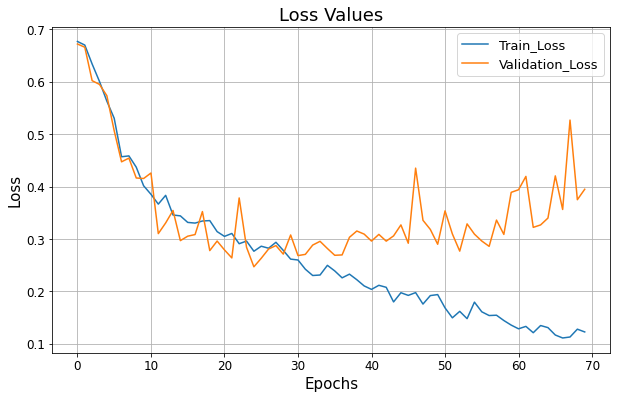

In [19]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/loss_b{batch_size}_e{epochs}_v1.png', dpi=300)

### Testing
#### Sample

Truth: scene 	 Prediction: scene 	 Result: Right


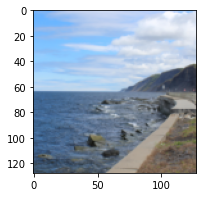

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


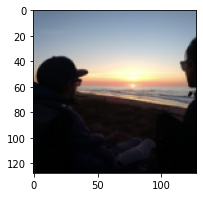

Truth: person 	 Prediction: person 	 Result: Right


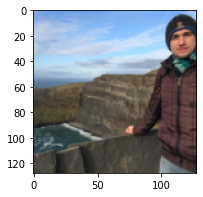

Truth: scene 	 Prediction: scene 	 Result: Right


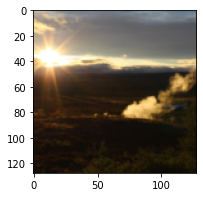

In [23]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
cnn.eval()
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset

In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 597 test images: 88 %


### Script Runtime Result

In [22]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 04:46:56 hh:mm:ss
